In [16]:
import numpy
import matplotlib.pyplot as plt

SAMPLEFREQ = 44100

In [5]:
import pyaudio


def aufnahme():
    FORMAT = pyaudio.paInt16
    FRAMESIZE = 1024
    NOFFRAMES = 220
    p = pyaudio.PyAudio()
    print("running")
    stream = p.open(format=FORMAT,channels=1,rate=SAMPLEFREQ,
    input=True,frames_per_buffer=FRAMESIZE)
    data = stream.read(NOFFRAMES*FRAMESIZE)
    decoded = numpy.frombuffer(data,dtype=numpy.int16);
    stream.stop_stream()
    stream.close()
    p.terminate()
    print("done")
    numpy.save("../Versuch4/file",decoded)
    plt.plot(decoded)
    plt.show()
#aufnahme()

ModuleNotFoundError: No module named 'pyaudio'

5.108390022675737
1.0


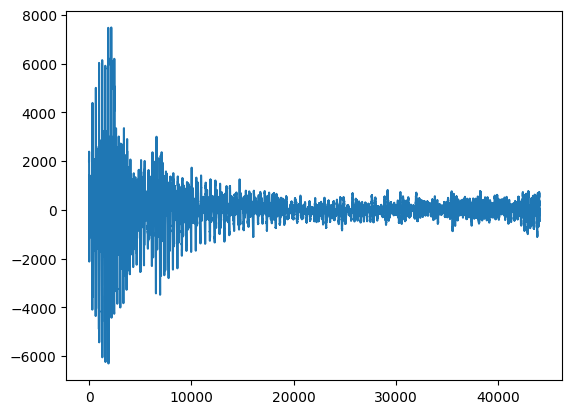

In [18]:

def trigger(path, threshold):
    sample = numpy.load(path)
    x = []
    for i in range(len(sample)):
        if sample[i] >= threshold:
            x = sample[i:]
            break
    return x[0:SAMPLEFREQ]


test = trigger("./file.npy",2000)
plt.plot(test)

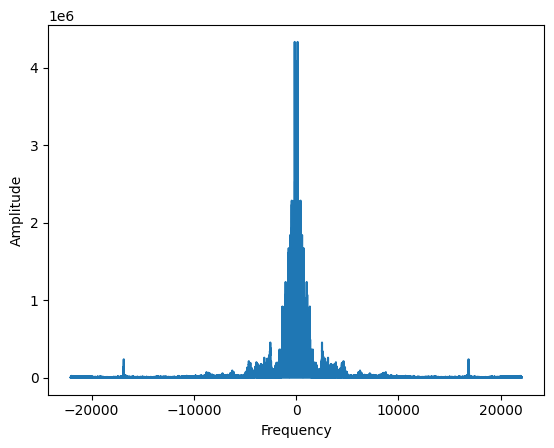

In [4]:

def calculate_amplitude_spectrum(signal):
    n = len(signal)
    frequencies = numpy.fft.fftfreq(n, d=1/SAMPLEFREQ)
    spectrum = numpy.fft.fft(signal)
    amplitude_spectrum = numpy.abs(spectrum)
    return frequencies, amplitude_spectrum

frequencies, amplitude_spectrum = calculate_amplitude_spectrum(test)
plt.plot(frequencies, amplitude_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()


Windowing